In [8]:
import torch
import torchaudio
import librosa
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from librosa.sequence import dtw
from transformers import Wav2Vec2Model, Wav2Vec2Processor, pipeline

In [9]:
truth_path = "no_lisp.wav"
rec_path = "lisp.wav"

In [10]:
y_truth, sr_truth = librosa.load(truth_path, sr=16000)
y_rec, sr_rec = librosa.load(rec_path, sr=16000)

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h").to(device)
model.eval()

def extract_embeddings(audio, model, device):
    """Return framewise embeddings for audio"""
    # Convert to torch tensor directly
    audio_tensor = torch.FloatTensor(audio).unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = model(audio_tensor).last_hidden_state.squeeze(0).cpu()
    return outputs

/Users/vincenth./miniconda3/envs/hacktx25/lib/python3.11/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2Model: ['lm_head.bias', 'lm_head.weight']
- This IS expected if you are initializing Wav2Vec2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2Model were not initialized from the model checkpoin

In [12]:
emb_truth = extract_embeddings(y_truth, model, device)
emb_rec = extract_embeddings(y_rec, model, device)

print("Truth embeddings:", emb_truth.shape)
print("Recorded embeddings:", emb_rec.shape)

Truth embeddings: torch.Size([689, 768])
Recorded embeddings: torch.Size([1257, 768])


=== Embedding Verification ===
Truth embeddings shape: torch.Size([689, 768])
Recorded embeddings shape: torch.Size([1257, 768])
Truth embeddings type: <class 'torch.Tensor'>
Recorded embeddings type: <class 'torch.Tensor'>
Truth embeddings min/max: -2.7596 / 3.3118
Recorded embeddings min/max: -2.3980 / 3.0185
Truth embeddings mean: -0.0004
Recorded embeddings mean: -0.0008


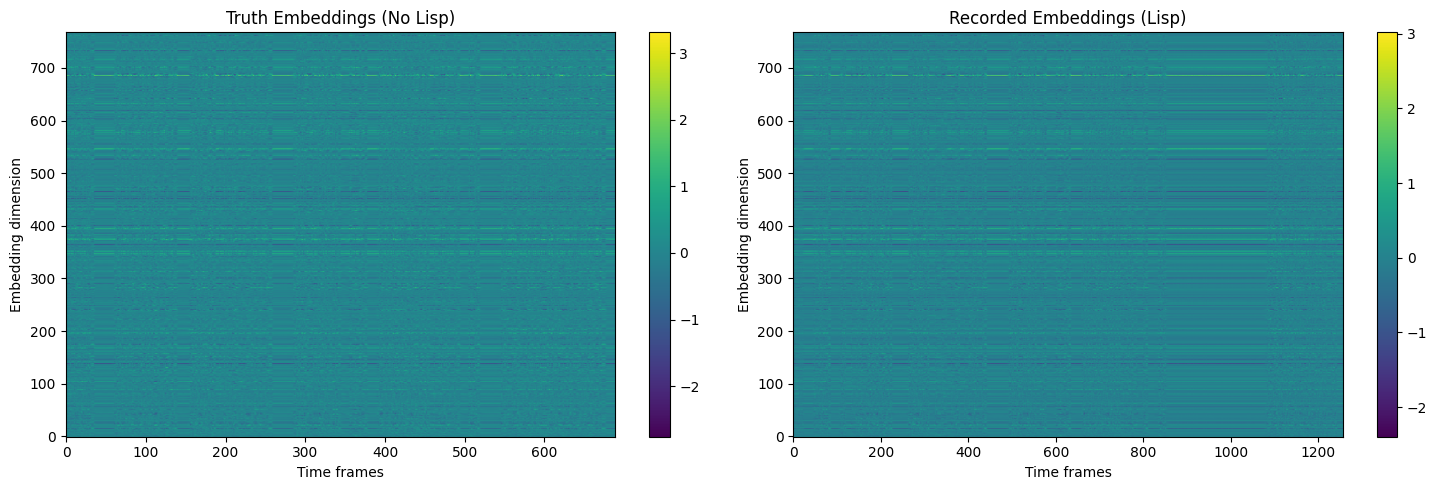


Contains NaN - Truth: False
Contains NaN - Recorded: False
All zeros - Truth: False
All zeros - Recorded: False


In [13]:
# Verify embeddings were properly extracted
print("=== Embedding Verification ===")
print(f"Truth embeddings shape: {emb_truth.shape}")
print(f"Recorded embeddings shape: {emb_rec.shape}")
print(f"Truth embeddings type: {type(emb_truth)}")
print(f"Recorded embeddings type: {type(emb_rec)}")
print(f"Truth embeddings min/max: {emb_truth.min():.4f} / {emb_truth.max():.4f}")
print(f"Recorded embeddings min/max: {emb_rec.min():.4f} / {emb_rec.max():.4f}")
print(f"Truth embeddings mean: {emb_truth.mean():.4f}")
print(f"Recorded embeddings mean: {emb_rec.mean():.4f}")

# Visualize the embeddings
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot truth embeddings
im1 = axes[0].imshow(emb_truth.T, aspect='auto', cmap='viridis', origin='lower')
axes[0].set_title('Truth Embeddings (No Lisp)')
axes[0].set_xlabel('Time frames')
axes[0].set_ylabel('Embedding dimension')
plt.colorbar(im1, ax=axes[0])

# Plot recorded embeddings
im2 = axes[1].imshow(emb_rec.T, aspect='auto', cmap='viridis', origin='lower')
axes[1].set_title('Recorded Embeddings (Lisp)')
axes[1].set_xlabel('Time frames')
axes[1].set_ylabel('Embedding dimension')
plt.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()

# Check if embeddings have reasonable values (not all zeros, not NaN)
print(f"\nContains NaN - Truth: {torch.isnan(emb_truth).any()}")
print(f"Contains NaN - Recorded: {torch.isnan(emb_rec).any()}")
print(f"All zeros - Truth: {(emb_truth == 0).all()}")
print(f"All zeros - Recorded: {(emb_rec == 0).all()}")

In [14]:
# Use cosine distance for embeddings
D = cdist(emb_rec, emb_truth, metric='cosine')
_, wp = dtw(C=D, subseq=True)  # allow gaps at start/end
wp = np.array(wp)  # shape: [num_aligned_frames, 2]

print("Alignment path shape:", wp.shape)

Alignment path shape: (1278, 2)


=== Alignment Path Verification ===
Alignment path shape: (1278, 2)
Number of aligned frames: 1278
Recorded frames aligned: 0 to 688 (out of 1257)
Truth frames aligned: 0 to 1256 (out of 689)

First 10 alignment pairs (rec_frame, truth_frame):
[[ 688 1256]
 [ 688 1255]
 [ 687 1254]
 [ 686 1253]
 [ 685 1252]
 [ 684 1251]
 [ 683 1250]
 [ 682 1249]
 [ 681 1248]
 [ 680 1247]]

Last 10 alignment pairs:
[[3 9]
 [3 8]
 [3 7]
 [3 6]
 [3 5]
 [2 4]
 [1 3]
 [0 2]
 [0 1]
 [0 0]]


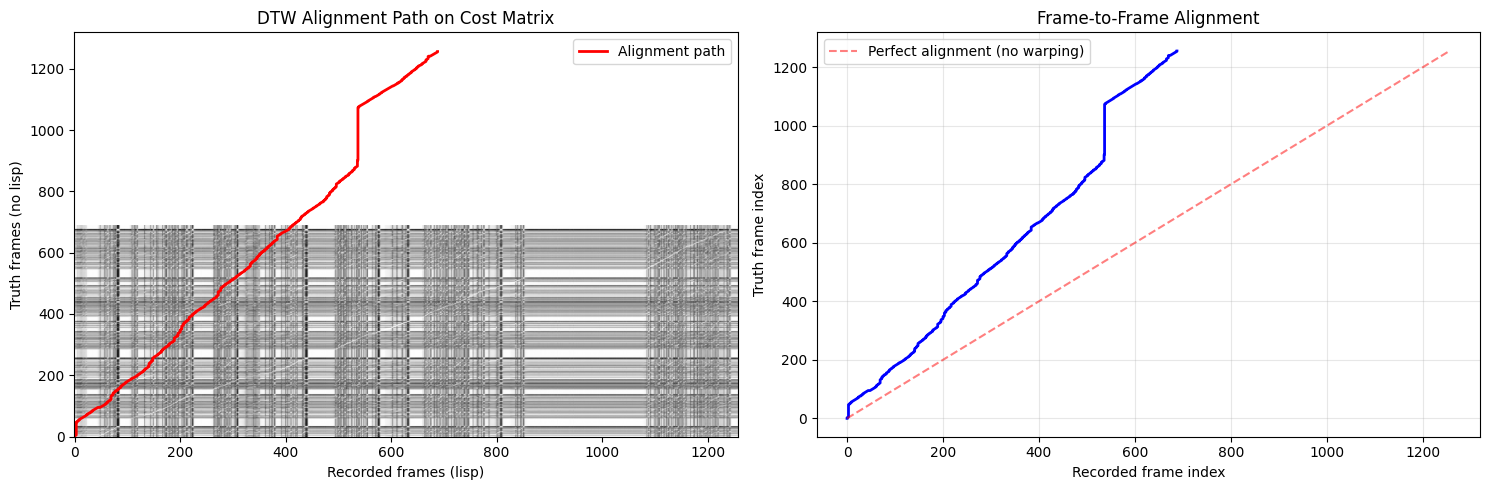


=== Monotonicity Check ===
Recorded frames always move forward: False
Truth frames always move forward: False
Average warping factor: 1.82x
Alignment covers 1278 frames


In [15]:
# Verify alignment path
print("=== Alignment Path Verification ===")
print(f"Alignment path shape: {wp.shape}")
print(f"Number of aligned frames: {len(wp)}")
print(f"Recorded frames aligned: {wp[:, 0].min()} to {wp[:, 0].max()} (out of {len(emb_rec)})")
print(f"Truth frames aligned: {wp[:, 1].min()} to {wp[:, 1].max()} (out of {len(emb_truth)})")
print(f"\nFirst 10 alignment pairs (rec_frame, truth_frame):")
print(wp[:10])
print(f"\nLast 10 alignment pairs:")
print(wp[-10:])

# Visualize the alignment path
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Alignment path on cost matrix
axes[0].imshow(D.T, origin='lower', cmap='gray_r', aspect='auto')
axes[0].plot(wp[:, 0], wp[:, 1], 'r-', linewidth=2, label='Alignment path')
axes[0].set_xlabel('Recorded frames (lisp)')
axes[0].set_ylabel('Truth frames (no lisp)')
axes[0].set_title('DTW Alignment Path on Cost Matrix')
axes[0].legend()

# Plot 2: Alignment path showing time warping
axes[1].plot(wp[:, 0], wp[:, 1], 'b-', linewidth=2)
axes[1].plot([0, max(len(emb_rec), len(emb_truth))], 
             [0, max(len(emb_rec), len(emb_truth))], 
             'r--', alpha=0.5, label='Perfect alignment (no warping)')
axes[1].set_xlabel('Recorded frame index')
axes[1].set_ylabel('Truth frame index')
axes[1].set_title('Frame-to-Frame Alignment')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Check for monotonicity (alignment should generally move forward)
rec_diffs = np.diff(wp[:, 0])
truth_diffs = np.diff(wp[:, 1])
print(f"\n=== Monotonicity Check ===")
print(f"Recorded frames always move forward: {(rec_diffs >= 0).all()}")
print(f"Truth frames always move forward: {(truth_diffs >= 0).all()}")
print(f"Average warping factor: {len(emb_rec) / len(emb_truth):.2f}x")
print(f"Alignment covers {len(wp)} frames")

Distance matrix D shape: (1257, 689)
emb_rec shape: torch.Size([1257, 768]), emb_truth shape: torch.Size([689, 768])
Alignment path wp shape: (1278, 2)
wp column 0 range: 0 to 688
wp column 1 range: 0 to 1256

=== Phoneme Mismatch Analysis ===
Average cosine distance along path: 0.0722
Min/Max distance: 0.0083 / 0.9186
Threshold for problematic regions: 0.0857
Number of problematic frames: 320 / 1278 (25.0%)

=== Top 5 Problematic Regions ===
1. Frames 12-89 (rec time 24.88s - 23.44s)
   Avg distance: 0.2076
2. Frames 107-146 (rec time 23.08s - 22.34s)
   Avg distance: 0.0714
3. Frames 157-160 (rec time 22.14s - 22.08s)
   Avg distance: 0.0962
4. Frames 413-421 (rec time 17.02s - 16.88s)
   Avg distance: 0.0864
5. Frames 464-464 (rec time 16.02s - 16.02s)
   Avg distance: 0.1066


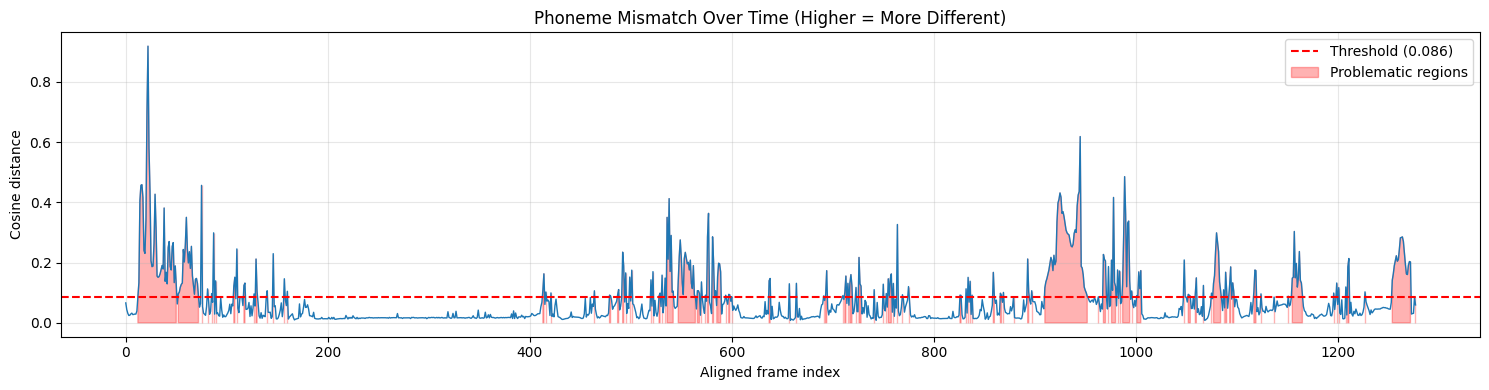

In [16]:
# First, let's verify the dimensions
print(f"Distance matrix D shape: {D.shape}")
print(f"emb_rec shape: {emb_rec.shape}, emb_truth shape: {emb_truth.shape}")
print(f"Alignment path wp shape: {wp.shape}")
print(f"wp column 0 range: {wp[:, 0].min()} to {wp[:, 0].max()}")
print(f"wp column 1 range: {wp[:, 1].min()} to {wp[:, 1].max()}")

# The DTW path is returned as (reference_index, query_index)
# D was computed as cdist(emb_rec, emb_truth), so D[i,j] = distance(emb_rec[i], emb_truth[j])
# wp is (truth_index, rec_index) so we need to reverse: D[wp[i,1], wp[i,0]]

# Calculate per-frame distance along the alignment path
aligned_distances = np.array([D[wp[i, 1], wp[i, 0]] for i in range(len(wp))])

# Find problematic regions (high distance = mispronunciation)
threshold = np.percentile(aligned_distances, 75)  # Top 25% worst matches
problematic_frames = np.where(aligned_distances > threshold)[0]

print("\n=== Phoneme Mismatch Analysis ===")
print(f"Average cosine distance along path: {aligned_distances.mean():.4f}")
print(f"Min/Max distance: {aligned_distances.min():.4f} / {aligned_distances.max():.4f}")
print(f"Threshold for problematic regions: {threshold:.4f}")
print(f"Number of problematic frames: {len(problematic_frames)} / {len(wp)} ({100*len(problematic_frames)/len(wp):.1f}%)")

# Find contiguous problematic regions
problematic_regions = []
if len(problematic_frames) > 0:
    start = problematic_frames[0]
    for i in range(1, len(problematic_frames)):
        if problematic_frames[i] - problematic_frames[i-1] > 10:  # Gap of 10+ frames = new region
            problematic_regions.append((start, problematic_frames[i-1]))
            start = problematic_frames[i]
    problematic_regions.append((start, problematic_frames[-1]))

print(f"\n=== Top {min(5, len(problematic_regions))} Problematic Regions ===")
for i, (start, end) in enumerate(problematic_regions[:5]):
    rec_frame = wp[start, 1]  # Column 1 is rec_index
    truth_frame = wp[start, 0]  # Column 0 is truth_index
    # Convert frames to time (assuming 20ms per frame for wav2vec2)
    time_start = rec_frame * 0.02
    time_end = wp[end, 1] * 0.02
    avg_dist = aligned_distances[start:end+1].mean()
    print(f"{i+1}. Frames {start}-{end} (rec time {time_start:.2f}s - {time_end:.2f}s)")
    print(f"   Avg distance: {avg_dist:.4f}")

# Visualize the mismatch over time
plt.figure(figsize=(15, 4))
plt.plot(aligned_distances, linewidth=1)
plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold ({threshold:.3f})')
plt.fill_between(range(len(aligned_distances)), 0, aligned_distances, 
                 where=aligned_distances > threshold, alpha=0.3, color='red', 
                 label='Problematic regions')
plt.xlabel('Aligned frame index')
plt.ylabel('Cosine distance')
plt.title('Phoneme Mismatch Over Time (Higher = More Different)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [17]:
# ⚠️ IMPORTANT: RESTART KERNEL BEFORE RUNNING NEXT CELL ⚠️
# 
# The phonemizer library (used by the IPA model) checks for espeak when it's first imported.
# Once checked, it's cached, so environment variables set later won't work.
#
# To restart kernel: Click "Restart" in the toolbar, or run this cell:

import IPython
print("Click 'Restart' in the Jupyter toolbar above, then run all cells from the beginning.")
print("Or uncomment the line below and run this cell to auto-restart:")
print()
print("# IPython.Application.instance().kernel.do_shutdown(True)")


Click 'Restart' in the Jupyter toolbar above, then run all cells from the beginning.
Or uncomment the line below and run this cell to auto-restart:

# IPython.Application.instance().kernel.do_shutdown(True)


In [18]:
# Using character-level CTC model instead of espeak-based IPA model
# This model outputs characters but we can still identify phonetic differences

from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor

print("Loading character-level phoneme recognition model...")
phoneme_model_name = "facebook/wav2vec2-base-960h"  # Character-level English ASR
phoneme_processor = Wav2Vec2Processor.from_pretrained(phoneme_model_name)
phoneme_model = Wav2Vec2ForCTC.from_pretrained(phoneme_model_name).to(device)
phoneme_model.eval()

def get_phonemes(audio, processor, model, device):
    """Extract character sequence and logits from audio"""
    # Process audio
    inputs = processor(audio, sampling_rate=16000, return_tensors="pt", padding=True)
    input_values = inputs.input_values.to(device)
    
    with torch.no_grad():
        logits = model(input_values).logits
    
    # Get predicted characters
    predicted_ids = torch.argmax(logits, dim=-1)
    transcription = processor.batch_decode(predicted_ids)[0]
    
    return transcription, logits

print("✓ Model loaded successfully!")

# Get phonemes for both recordings
print("\nExtracting transcriptions from recordings...")
phonemes_truth, logits_truth = get_phonemes(y_truth, phoneme_processor, phoneme_model, device)
phonemes_rec, logits_rec = get_phonemes(y_rec, phoneme_processor, phoneme_model, device)

print(f"\nTruth transcription: '{phonemes_truth}'")
print(f"\nRecorded transcription: '{phonemes_rec}'")
print(f"\nLogits shape - Truth: {logits_truth.shape}, Recorded: {logits_rec.shape}")

# Highlight differences
if phonemes_truth.lower() != phonemes_rec.lower():
    print("\n⚠️ TRANSCRIPTION DIFFERENCES DETECTED")
    print("This suggests phonetic differences between the recordings")
else:
    print("\n✓ Transcriptions match - differences are at acoustic level only")

Loading character-level phoneme recognition model...


Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Model loaded successfully!

Extracting transcriptions from recordings...

Truth transcription: 'HEY THERE I'M SO GLAD YOU COULD MAKE IT WE'RE GOING TO HAVE SO MUCH FUN TO DAY I'VE BEEN PLANNING THIS FOR AGES AND I THINK IT'S GOING TO BE THE BEST DAY EVER I CAN'T WAIT TO SEE WHAT ADVENTURES AWAIT YOU'

Recorded transcription: 'HEY THERE I'M SO GLAD YOU CUN MAKE IT WE'RE GOING TO HAVE THOUG MUCH FUN TO DAY I'VE BEEN PLANNING THIS FOR AGES AND I THINK IT'S GOING TO BE THE BEST DAY EVER I CAN'T WAIT TO SEE WHAT ADVENTURES AWAIK USE'

Logits shape - Truth: torch.Size([1, 689, 32]), Recorded: torch.Size([1, 1257, 32])

⚠️ TRANSCRIPTION DIFFERENCES DETECTED
This suggests phonetic differences between the recordings

Truth transcription: 'HEY THERE I'M SO GLAD YOU COULD MAKE IT WE'RE GOING TO HAVE SO MUCH FUN TO DAY I'VE BEEN PLANNING THIS FOR AGES AND I THINK IT'S GOING TO BE THE BEST DAY EVER I CAN'T WAIT TO SEE WHAT ADVENTURES AWAIT YOU'

Recorded transcription: 'HEY THERE I'M SO GLAD YOU 

In [22]:
# Direct transcription comparison to find phonetic differences
print("=== Direct Transcription Analysis ===\n")

# Split transcriptions into words
truth_words = phonemes_truth.split()
rec_words = phonemes_rec.split()

print(f"Truth has {len(truth_words)} words")
print(f"Recorded has {len(rec_words)} words\n")

# Find word-level differences using simple alignment
from difflib import SequenceMatcher

matcher = SequenceMatcher(None, truth_words, rec_words)
differences = []

print("=== Word-Level Differences ===\n")
for tag, i1, i2, j1, j2 in matcher.get_opcodes():
    if tag == 'replace':
        for k in range(max(i2-i1, j2-j1)):
            truth_word = truth_words[i1+k] if i1+k < i2 else '(missing)'
            rec_word = rec_words[j1+k] if j1+k < j2 else '(missing)'
            if truth_word != rec_word:
                differences.append((truth_word, rec_word, i1+k))
                print(f"Word {i1+k+1}: '{truth_word}' → '{rec_word}'")
    elif tag == 'delete':
        for k in range(i2-i1):
            differences.append((truth_words[i1+k], '(deleted)', i1+k))
            print(f"Word {i1+k+1}: '{truth_words[i1+k]}' → (deleted)")
    elif tag == 'insert':
        for k in range(j2-j1):
            differences.append(('(inserted)', rec_words[j1+k], i1))
            print(f"Word {i1+1}: (inserted) → '{rec_words[j1+k]}'")

print(f"\n=== Lisp Analysis ({len(differences)} differences found) ===\n")

lisp_patterns = {
    's_missing': [],
    's_to_th': [],
    'z_issues': [],
    'other': []
}

for truth_word, rec_word, pos in differences:
    truth_lower = truth_word.lower() if truth_word != '(missing)' and truth_word != '(inserted)' else ''
    rec_lower = rec_word.lower() if rec_word != '(missing)' and rec_word != '(deleted)' else ''
    
    # Check for 's' related issues (classic lisp)
    if 's' in truth_lower and 's' not in rec_lower:
        if 'th' in rec_lower or 'h' in rec_lower:
            lisp_patterns['s_to_th'].append((truth_word, rec_word))
            print(f"🔍 LISP (s→th): '{truth_word}' → '{rec_word}'")
        else:
            lisp_patterns['s_missing'].append((truth_word, rec_word))
            print(f"🔍 LISP (s missing): '{truth_word}' → '{rec_word}'")
    # Check for 'z' issues
    elif 'z' in truth_lower and 'z' not in rec_lower:
        lisp_patterns['z_issues'].append((truth_word, rec_word))
        print(f"🔍 LISP (z issue): '{truth_word}' → '{rec_word}'")
    # Check for other sibilant issues
    elif any(c in truth_lower for c in ['sh', 'ch', 'zh']):
        lisp_patterns['other'].append((truth_word, rec_word))
        print(f"⚠️  Sibilant change: '{truth_word}' → '{rec_word}'")
    else:
        lisp_patterns['other'].append((truth_word, rec_word))
        print(f"ℹ️  Other difference: '{truth_word}' → '{rec_word}'")

print(f"\n=== Summary ===")
print(f"Total differences: {len(differences)}")
print(f"  s→th substitutions: {len(lisp_patterns['s_to_th'])}")
print(f"  s missing/changed: {len(lisp_patterns['s_missing'])}")
print(f"  z issues: {len(lisp_patterns['z_issues'])}")
print(f"  Other differences: {len(lisp_patterns['other'])}")

if lisp_patterns['s_to_th'] or lisp_patterns['s_missing']:
    print(f"\n✅ LISP DETECTED: Clear evidence of 's' sound substitution/deletion")
else:
    print(f"\n❌ NO CLEAR LISP: Differences may be other pronunciation issues")

=== Direct Transcription Analysis ===

Truth has 44 words
Recorded has 44 words

=== Word-Level Differences ===

Word 7: 'COULD' → 'CUN'
Word 14: 'SO' → 'THOUG'
Word 43: 'AWAIT' → 'AWAIK'
Word 44: 'YOU' → 'USE'

=== Lisp Analysis (4 differences found) ===

ℹ️  Other difference: 'COULD' → 'CUN'
🔍 LISP (s→th): 'SO' → 'THOUG'
ℹ️  Other difference: 'AWAIT' → 'AWAIK'
ℹ️  Other difference: 'YOU' → 'USE'

=== Summary ===
Total differences: 4
  s→th substitutions: 1
  s missing/changed: 0
  z issues: 0
  Other differences: 3

✅ LISP DETECTED: Clear evidence of 's' sound substitution/deletion
